In [1]:
#@title Bibliotecas padrões
import pandas as pd
import pandas.io.sql as sqlio
import sys
import psycopg2
from ydata_profiling import ProfileReport
import numpy as np
from botocore import UNSIGNED
from botocore.config import Config
from urllib.parse import quote_plus
from pyathena import connect
import boto3
import boto3.session
from botocore import exceptions
import seaborn as sns
import plotly.express as px

#Carregando as bibliotecas necessárias para a análise estatística
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 8)
import statsmodels.api as sm
import statsmodels.tsa as tsa
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_process import arma_generate_sample

In [2]:
#ponte de conexão com o redshift
connection = psycopg2.connect(dbname="dw_amorsaude",
                  user="gabriel_guilherme",
                  password="PgQ1yBg9hzHJfmc",
                  host ="amorsaude-cluster-redshift.cmc4ev2oyczd.us-east-1.redshift.amazonaws.com",
                  port = 5439)

In [3]:

df_profissionais = '''
--BASE DE PROFISSIONAIS MÉDICOS PARA ANÁLISE DE PERFIL
with atendimento as (
	select 
		ag.id_profissional,
		ag.id_unidade,
		count(ag.id_agendamento) as qtd_atendimentos 
	from tb_consolidacao_agendamentos  ag 
	--where ag.datadoatendimento between '2023-04-01' and '2023-06-30'
	where ag.status_id in (33, 207, 202, 2, 200, 203, 5, 204, 201, 205, 4, 206, 3)
	and ag.id_especialidade = 96
	--and ag.id_unidade = 19794
	group by ag.id_profissional, ag.id_unidade),
propostas as (
	select 
		pp.profissionalid as id_profissional,
		pp.unidadeid id_unidade,
		count(pp.id) as qtd_propostas
	from stg_propostas pp
	--where dataproposta between '2023-04-01' and '2023-06-30'
	where pp.especialidade_id = 96
	group by pp.profissionalid, pp.unidadeid),
propostas_executadas as (
	select 
		pp.profissionalid as id_profissional,
		pp.unidadeid id_unidade,
		count(pp.id) as qtd_propostas_executadas
	from stg_propostas pp
	--where dataproposta between '2023-04-01' and '2023-06-30'
	where pp.especialidade_id = 96
	and pp.staid = 5
	group by pp.profissionalid, pp.unidadeid),
infos_profissionais as (
	select 
		spu.profissional_id as id_profissional,
		count( distinct spu.unidade_id) as qtd_unidades,
		case when count(spu.unidade_id) > 1 then 1 else 0 end multiplas_unidades,
		spe.qtd_especialidades,
		spe.multiplas_especialidades
	from stg_profissionais_unidades spu
	join (select 
			spe.profissional_id as id_profissional,
			count( distinct spe.especialidade_id) as qtd_especialidades,
			case when count(spe.especialidade_id) > 1 then 1 else 0 end multiplas_especialidades
		  from stg_profissional_especialidades spe
		  where spe.especialidade_id = 96 --filtrando apenas cardio
		  group by spe.profissional_id) spe on spu.profissional_id = spe.id_profissional
	group by spu.profissional_id, spe.qtd_especialidades, spe.multiplas_especialidades)
select
	sp.id as id_profissional,
	--spu.unidade_id, --retirado para diminuir a granularidade da analise num primeiro momento
	--su.nome_fantasia nome_unidade, --retirado para diminuir a granularidade da analise num primeiro momento
	sr.descricao,
	sp.nome_profissional,
	datediff(year, sp.nascimento, getdate()) as idade,
	datediff(year, sp.sys_date, getdate()) as anos_empresa,
	datediff(month, sp.sys_date, getdate()) as meses_empresa,
	sp.sexo_id,
	ss.nomesexo sexo,
	sp.sys_active,
	sum(att.qtd_atendimentos) as total_atendimentos,
	sum(pp.qtd_propostas) as total_propostas,
	sum(pe.qtd_propostas_executadas) as total_executada,
	sum(pe.qtd_propostas_executadas) / sum(pp.qtd_propostas)::float as conversao_propostas,
	sum(pp.qtd_propostas)/ sum(att.qtd_atendimentos)::float as conversao_atendimento
from stg_profissionais sp
join stg_profissionais_unidades spu on spu.profissional_id = sp.id
join stg_unidades su on su.id = spu.unidade_id 
join stg_sexo ss on sp.sexo_id = ss.id
join atendimento att on att.id_profissional = sp.id and spu.unidade_id = att.id_unidade
join propostas pp on pp.id_profissional = sp.id and spu.unidade_id = pp.id_unidade
join propostas_executadas pe on pe.id_profissional = sp.id and spu.unidade_id = pe.id_unidade
join stg_unidades_regioes sr on sr.id = su.regiao_id 
join infos_profissionais ip on sp.id = ip.id_profissional
group by 
sp.id,
	--spu.unidade_id, --retirado para diminuir a granularidade da analise num primeiro momento
	--su.nome_fantasia nome_unidade, --retirado para diminuir a granularidade da analise num primeiro momento
	sr.descricao,
	sp.nome_profissional,
	datediff(year, sp.nascimento, getdate()),
	datediff(year, sp.sys_date, getdate()) ,
	datediff(month, sp.sys_date, getdate()),
	sp.sexo_id,
	ss.nomesexo,
	sp.sys_active
 '''


In [4]:
dfp = pd.read_sql_query(df_profissionais,con=connection)

/tmp/ipykernel_1180/1035449778.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dfp = pd.read_sql_query(df_profissionais,con=connection)


In [5]:
dfp

,id_profissional,descricao,nome_profissional,idade,anos_empresa,meses_empresa,sexo_id,sexo,sys_active,total_atendimentos,total_propostas,total_executada,conversao_propostas,conversao_atendimento
0,504298,SP CAV,Jorge Luis Vivar Sanchez,36.0,1,13,1.0,Masculino,1,377,191,93,0.486911,0.506631
1,165668,SP Interior,Rafael Porto,41.0,3,37,1.0,Masculino,1,2793,426,248,0.582160,0.152524
2,234178,SP CAV,Reyves Lorenzoni Batista,33.0,5,62,1.0,Masculino,1,2601,1112,270,0.242806,0.427528
3,262469,NE2,Felipe Afonso Gonçalves,40.0,3,39,1.0,Masculino,1,4808,277,234,0.844765,0.057612
4,233409,CO,Carlos Fernando Vilarinho,64.0,5,62,1.0,Masculino,1,18627,1298,1032,0.795069,0.069684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,90,SP Interior,Adelaide Silveira Barros,51.0,3,36,2.0,Feminino,1,378,221,158,0.714932,0.584656
504,511791,RJ,Jorge Eduardo Andrade Negri,75.0,0,1,1.0,Masculino,1,9,3,1,0.333333,0.333333
505,251233,NE2,Camilo Paiva Cantidio,62.0,4,48,1.0,Masculino,1,2043,142,112,0.788732,0.069506
506,225501,Sul,Andre Luiz Ribeiro Gomes Capaverde,43.0,6,69,1.0,Masculino,1,812,45,40,0.888889,0.055419


In [6]:
#Verificando qual a média e desvio padrão da conversao_propostas conversao_atendimento para definições de bool
media_conversao_propostas = dfp['conversao_propostas'].mean()
mediana_conversao_propostas = dfp['conversao_propostas'].median()
desvio_padrao_conversao_propostas = dfp['conversao_propostas'].std()

media_conversao_atendimento = dfp['conversao_atendimento'].mean()
mediana_conversao_atendimento = dfp['conversao_atendimento'].median()
desvio_padrao_conversao_atendimento = dfp['conversao_atendimento'].std()

print("Média de conversão de propostas:", media_conversao_propostas)
print("Mediana de conversão de propostas:", mediana_conversao_propostas)
print("Desvio padrão de conversão de propostas:", desvio_padrao_conversao_propostas)

print("Média de conversão de atendimento:", media_conversao_atendimento)
print("Mediana de conversão de atendimento:", mediana_conversao_atendimento)
print("Desvio padrão de conversão de atendimento:", desvio_padrao_conversao_atendimento)

Média de conversão de propostas: 0.6452810277514632
Mediana de conversão de propostas: 0.6783661740558296
Desvio padrão de conversão de propostas: 0.2174102221964024
Média de conversão de atendimento: 0.3502318937845269
Mediana de conversão de atendimento: 0.202539321875168
Desvio padrão de conversão de atendimento: 0.6228258844155133


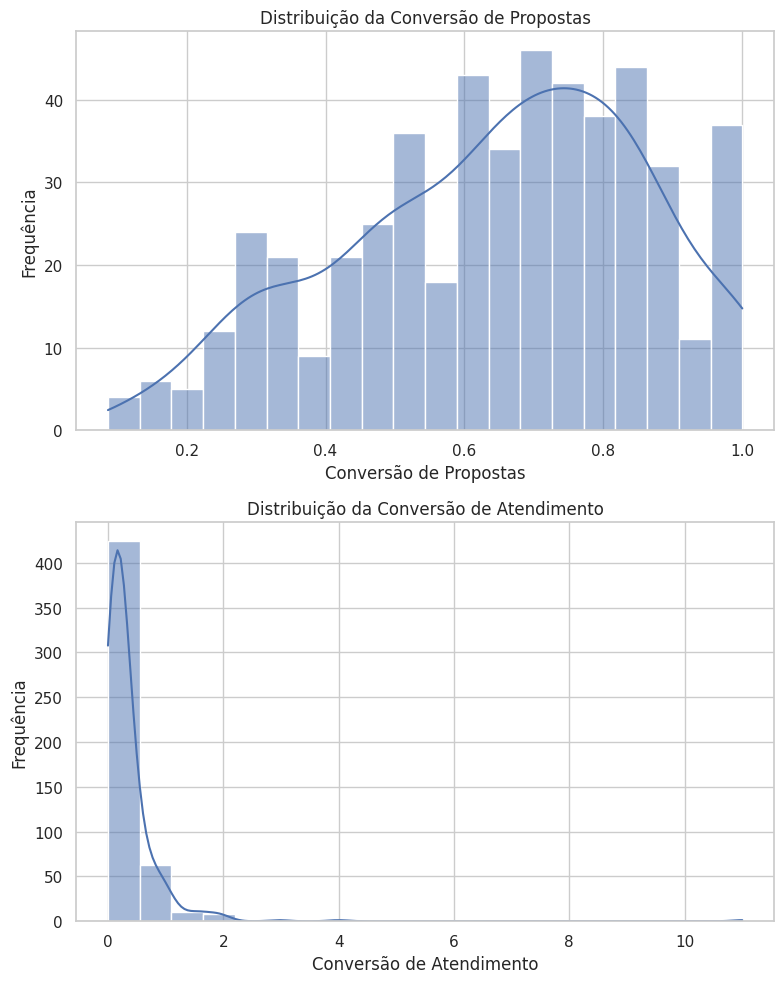

In [7]:
cor_personalizada = '#81cdd9'
sns.set_palette([cor_personalizada])

# Configurando o estilo dos gráficos
sns.set(style="whitegrid")

# Criando um subplot com 2 linhas e 1 coluna
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))

# Plotando o histograma da coluna "conversao_propostas"
sns.histplot(data=dfp, x='conversao_propostas', bins=20, ax=axes[0], kde=True)
axes[0].set_title('Distribuição da Conversão de Propostas')
axes[0].set_xlabel('Conversão de Propostas')
axes[0].set_ylabel('Frequência')

# Plotando o histograma da coluna "conversao_atendimento"
sns.histplot(data=dfp, x='conversao_atendimento', bins=20, ax=axes[1], kde=True)
axes[1].set_title('Distribuição da Conversão de Atendimento')
axes[1].set_xlabel('Conversão de Atendimento')
axes[1].set_ylabel('Frequência')

# Ajustando o layout dos subplots
plt.tight_layout()

# Exibindo os gráficos
plt.show()

In [8]:
# Calculando a média das colunas classificacao_atendimento e classificacao_propostas
media_classificacao_atendimento = dfp['conversao_atendimento'].mean()
media_classificacao_propostas = dfp['conversao_propostas'].mean()

# Criando as novas colunas 'classificacao_propostas' e 'classificacao_atendimento' com base nas médias
dfp['classificacao_propostas'] = np.where(dfp['conversao_propostas'] > media_classificacao_propostas, 1, 0)
dfp['classificacao_atendimento'] = np.where(dfp['conversao_atendimento'] > media_classificacao_atendimento, 1, 0)

In [9]:
# Criar as faixas para a coluna meses_empresa
faixas = [0, 12, 24, 36, 48, 60, float('inf')]
labels = ['até 1 ano', 'até 2 anos', 'até 3 anos', 'até 4 anos', 'até 5 anos', 'mais de 5 anos']

# Adicionar a nova coluna com as faixas
dfp['faixa_meses_empresa'] = pd.cut(dfp['meses_empresa'], bins=faixas, labels=labels, right=False)

In [10]:
data = {
    'idade': [25, 30, 42, 19, 55, 67, 39, 28, 21, 49]
}

df = pd.DataFrame(data)

# Definir os intervalos das faixas etárias
intervalos = [0, 20, 30, 40, 50, 60, float('inf')]  # Faixas etárias: (0-20], (20-30], (30-40], (40-50], (50-60], 60+

# Definir os rótulos das faixas etárias
rotulos = ['0-20', '21-30', '31-40', '41-50', '51-60', '60+']

# Adicionar uma nova coluna 'faixa_etaria' com base na coluna 'idade'
dfp['faixa_etaria'] = pd.cut(dfp['idade'], bins=intervalos, labels=rotulos)

In [11]:
dfp['ambas_classificacoes_1'] = dfp.apply(lambda row: 1 if row['classificacao_propostas'] == 1 and row['classificacao_atendimento'] == 1 else 0, axis=1)

In [12]:
dfp

,id_profissional,descricao,nome_profissional,idade,anos_empresa,meses_empresa,sexo_id,sexo,sys_active,total_atendimentos,total_propostas,total_executada,conversao_propostas,conversao_atendimento,classificacao_propostas,classificacao_atendimento,faixa_meses_empresa,faixa_etaria,ambas_classificacoes_1
0,504298,SP CAV,Jorge Luis Vivar Sanchez,36.0,1,13,1.0,Masculino,1,377,191,93,0.486911,0.506631,0,1,até 2 anos,31-40,0
1,165668,SP Interior,Rafael Porto,41.0,3,37,1.0,Masculino,1,2793,426,248,0.582160,0.152524,0,0,até 4 anos,41-50,0
2,234178,SP CAV,Reyves Lorenzoni Batista,33.0,5,62,1.0,Masculino,1,2601,1112,270,0.242806,0.427528,0,1,mais de 5 anos,31-40,0
3,262469,NE2,Felipe Afonso Gonçalves,40.0,3,39,1.0,Masculino,1,4808,277,234,0.844765,0.057612,1,0,até 4 anos,31-40,0
4,233409,CO,Carlos Fernando Vilarinho,64.0,5,62,1.0,Masculino,1,18627,1298,1032,0.795069,0.069684,1,0,mais de 5 anos,60+,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,90,SP Interior,Adelaide Silveira Barros,51.0,3,36,2.0,Feminino,1,378,221,158,0.714932,0.584656,1,1,até 4 anos,51-60,1
504,511791,RJ,Jorge Eduardo Andrade Negri,75.0,0,1,1.0,Masculino,1,9,3,1,0.333333,0.333333,0,0,até 1 ano,60+,0
505,251233,NE2,Camilo Paiva Cantidio,62.0,4,48,1.0,Masculino,1,2043,142,112,0.788732,0.069506,1,0,até 5 anos,60+,0
506,225501,Sul,Andre Luiz Ribeiro Gomes Capaverde,43.0,6,69,1.0,Masculino,1,812,45,40,0.888889,0.055419,1,0,mais de 5 anos,41-50,0


In [13]:
# Agrupar por faixa_etaria e calcular a soma de ambas_classificacoes_1
grupo_por_faixa_etaria = dfp.groupby('faixa_etaria')['ambas_classificacoes_1'].sum()

# Calcular a probabilidade de cada faixa etária ter ambas_classificacoes_1
probabilidade_faixa_etaria = grupo_por_faixa_etaria / grupo_por_faixa_etaria.sum()

# Criar um novo DataFrame com a soma e a probabilidade
df_resultado = pd.DataFrame({
    'soma_ambas_classificacoes_1': grupo_por_faixa_etaria,
    'probabilidade': probabilidade_faixa_etaria
}).reset_index()

# Agrupar por faixa_etaria e calcular a soma de ambas_classificacoes_1
grupo_por_faixa_etaria1 = dfp.groupby('faixa_meses_empresa')['ambas_classificacoes_1'].sum()

# Calcular a probabilidade de cada faixa etária ter ambas_classificacoes_1
probabilidade_faixa_etaria1 = grupo_por_faixa_etaria1 / grupo_por_faixa_etaria1.sum()

# Criar um novo DataFrame com a soma e a probabilidade
df_resultado1 = pd.DataFrame({
    'soma_ambas_classificacoes_1': grupo_por_faixa_etaria1,
    'probabilidade': probabilidade_faixa_etaria1
}).reset_index()

In [14]:
# Agrupar por soma da coluna "ambas_classificacoes_1" por faixa "faixa_meses_empresa"
grupo_por_meses_empresa = dfp.groupby('faixa_meses_empresa')['ambas_classificacoes_1'].sum()

# Agrupar por soma da coluna "ambas_classificacoes_1" por faixa "faixa_etaria"
grupo_por_faixa_etaria = dfp.groupby('faixa_etaria')['ambas_classificacoes_1'].sum()

print("Agrupado por faixa_meses_empresa:")
print(grupo_por_meses_empresa)

print("\nAgrupado por faixa_etaria:")
print(grupo_por_faixa_etaria)

Agrupado por faixa_meses_empresa:
faixa_meses_empresa
até 1 ano         21
até 2 anos         6
até 3 anos         4
até 4 anos         4
até 5 anos         5
mais de 5 anos     2
Name: ambas_classificacoes_1, dtype: int64

Agrupado por faixa_etaria:
faixa_etaria
0-20      0
21-30     1
31-40    16
41-50    13
51-60     5
60+       3
Name: ambas_classificacoes_1, dtype: int64


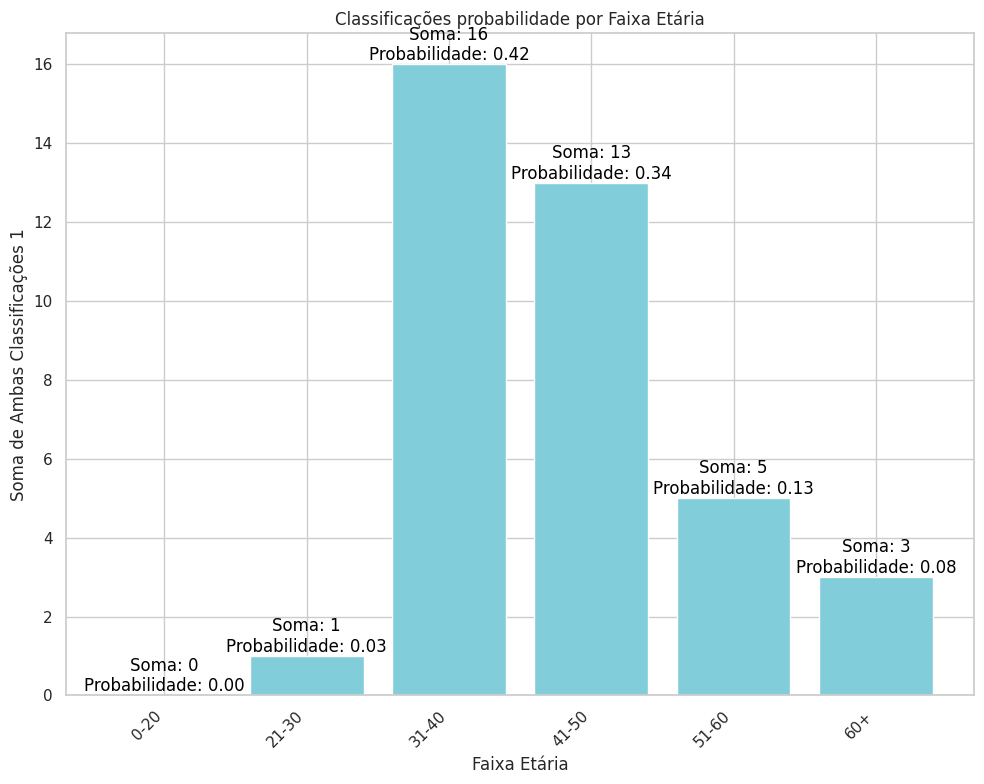

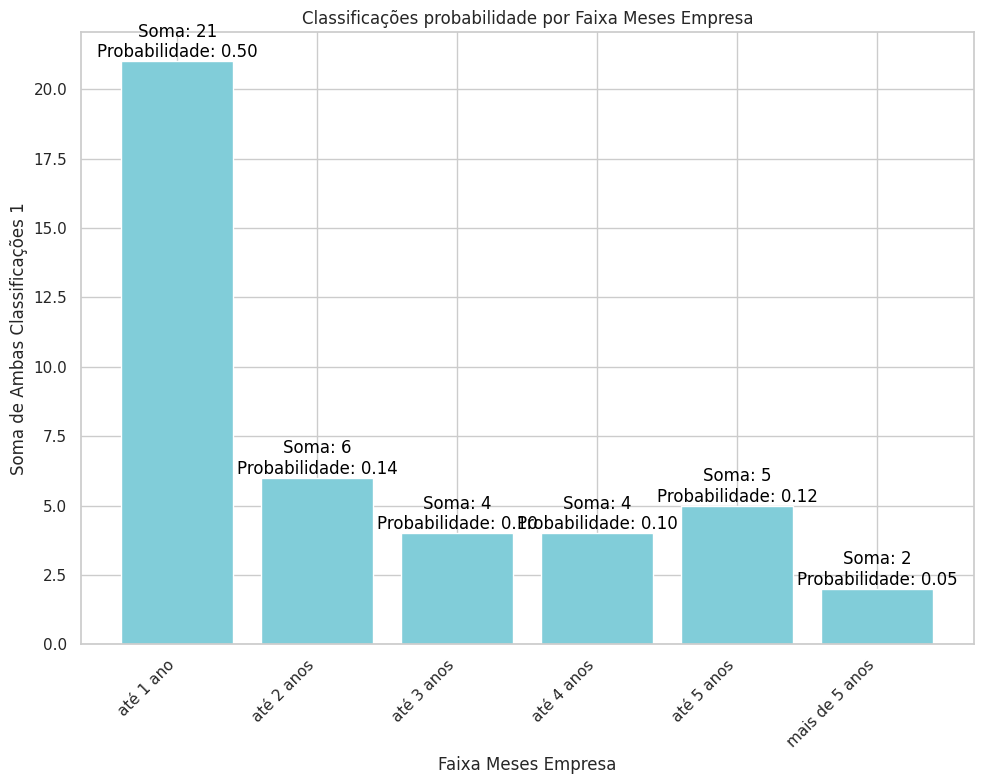

In [15]:
# Criar um novo DataFrame com a soma e a probabilidade

cor_personalizada = '#81cdd9'
sns.set_palette([cor_personalizada])

df_resultado = pd.DataFrame({
    'soma_ambas_classificacoes_1': grupo_por_faixa_etaria,
    'probabilidade': probabilidade_faixa_etaria
}).reset_index()

# Plotar gráfico de barras para df_resultado
plt.figure(figsize=(10, 8))
plt.bar(df_resultado['faixa_etaria'], df_resultado['soma_ambas_classificacoes_1'])
plt.xlabel('Faixa Etária')
plt.ylabel('Soma de Ambas Classificações 1')
plt.title('Classificações probabilidade por Faixa Etária')
plt.xticks(rotation=45, ha='right')

# Adicionar os rótulos de dados acima das barras
for i, value in enumerate(df_resultado['soma_ambas_classificacoes_1']):
    probabilidade = df_resultado['probabilidade'][i]
    plt.text(i, value, f'Soma: {value}\nProbabilidade: {probabilidade:.2f}', ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()

# Código para calcular grupo_por_faixa_etaria1 e probabilidade_faixa_etaria1...

# Criar um novo DataFrame com a soma e a probabilidade
df_resultado1 = pd.DataFrame({
    'soma_ambas_classificacoes_1': grupo_por_faixa_etaria1,
    'probabilidade': probabilidade_faixa_etaria1
}).reset_index()

# Plotar gráfico de barras para df_resultado1
plt.figure(figsize=(10, 8))
plt.bar(df_resultado1['faixa_meses_empresa'], df_resultado1['soma_ambas_classificacoes_1'])
plt.xlabel('Faixa Meses Empresa')
plt.ylabel('Soma de Ambas Classificações 1')
plt.title('Classificações probabilidade por Faixa Meses Empresa')
plt.xticks(rotation=45, ha='right')

# Adicionar os rótulos de dados acima das barras
for i, value in enumerate(df_resultado1['soma_ambas_classificacoes_1']):
    probabilidade = df_resultado1['probabilidade'][i]
    plt.text(i, value, f'Soma: {value}\nProbabilidade: {probabilidade:.2f}', ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()

In [16]:
# Agrupar por faixa_meses_empresa e calcular a soma de ambas_classificacoes_1 e a contagem de registros
grupo_por_meses_empresa = dfp.groupby('faixa_meses_empresa').agg({'ambas_classificacoes_1': 'sum', 'id_profissional': 'count'}).reset_index()

# Renomear as colunas
grupo_por_meses_empresa.rename(columns={'ambas_classificacoes_1': 'soma_ambas_classificacoes_1', 'id_profissional': 'qtde_registros'}, inplace=True)

# Agrupar por faixa_etaria e calcular a soma de ambas_classificacoes_1 e a contagem de registros
grupo_por_faixa_etaria = dfp.groupby('faixa_etaria').agg({'ambas_classificacoes_1': 'sum', 'id_profissional': 'count'}).reset_index()

# Renomear as colunas
grupo_por_faixa_etaria.rename(columns={'ambas_classificacoes_1': 'soma_ambas_classificacoes_1', 'id_profissional': 'qtde_registros'}, inplace=True)

print("Agrupado por faixa_meses_empresa:")
print(grupo_por_meses_empresa)

print("\nAgrupado por faixa_etaria:")
print(grupo_por_faixa_etaria)



Agrupado por faixa_meses_empresa:
  faixa_meses_empresa  soma_ambas_classificacoes_1  qtde_registros
0           até 1 ano                           21             117
1          até 2 anos                            6             103
2          até 3 anos                            4              70
3          até 4 anos                            4              76
4          até 5 anos                            5              59
5      mais de 5 anos                            2              83

Agrupado por faixa_etaria:
  faixa_etaria  soma_ambas_classificacoes_1  qtde_registros
0         0-20                            0               2
1        21-30                            1              23
2        31-40                           16             146
3        41-50                           13             137
4        51-60                            5              87
5          60+                            3              92


In [17]:
 soma_por_descricao = dfp.groupby('descricao')['total_atendimentos', 'total_propostas', 'total_executada'].sum()

# Calculando as duas novas colunas e adicionando ao DataFrame soma_por_descricao
soma_por_descricao['divisao_propostas_atendimentos'] = soma_por_descricao['total_propostas'] / soma_por_descricao['total_atendimentos']
soma_por_descricao['divisao_executada_propostas'] = soma_por_descricao['total_executada'] / soma_por_descricao['total_propostas']
#ordenando as novas colunas primeiro pela divisao_propostas_atendimentos e depois divisao_executada_propostas
soma_por_descricao_sorted = soma_por_descricao.sort_values(by=['divisao_propostas_atendimentos', 'divisao_executada_propostas'], ascending=[False, False])


/tmp/ipykernel_1180/3958022216.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  soma_por_descricao = dfp.groupby('descricao')['total_atendimentos', 'total_propostas', 'total_executada'].sum()


In [18]:
#função de plotagem

def plot_divisoes(df):
    
    sns.set_palette("Set2")
    
    # Criar o gráfico de colunas
    plt.figure(figsize=(10, 6))  # Tamanho do gráfico (opcional)

    # Definir as posições das barras no eixo x
    x = range(len(df))

    # Plotar as barras para divisao_propostas_atendimentos em azul e divisao_executada_propostas em verde
    plt.bar(x, df['divisao_propostas_atendimentos'], width=0.4, label='Propostas/Atendimentos')
    plt.bar([i + 0.4 for i in x], df['divisao_executada_propostas'], width=0.4, label='Executada/Propostas', alpha=0.7)

    # Definir os rótulos das barras
    plt.xticks([i + 0.2 for i in x], df.index, rotation=45, ha='right')

    # Adicionar os rótulos de dados acima das barras (divisao_propostas_atendimentos)
    for i, value in enumerate(df['divisao_propostas_atendimentos']):
        plt.text(i, value, f'{value:.2f}', ha='center', va='bottom', color='black')

    # Adicionar os rótulos de dados acima das barras (divisao_executada_propostas)
    for i, value in enumerate(df['divisao_executada_propostas']):
        plt.text(i + 0.4, value, f'{value:.2f}', ha='center', va='bottom', color='black')

    # Definir o título e os rótulos dos eixos
    plt.title('Divisão Propostas/Atendimentos e Executada/Propostas por faixa_meses_empresa (valores em decimais)')
    plt.xlabel('Descrição')
    plt.ylabel('Divisão')

    # Exibir a legenda
    plt.legend()

    # Exibir o gráfico
    plt.tight_layout()  # Ajustando o layout para evitar cortes nos rótulos
    plt.show()

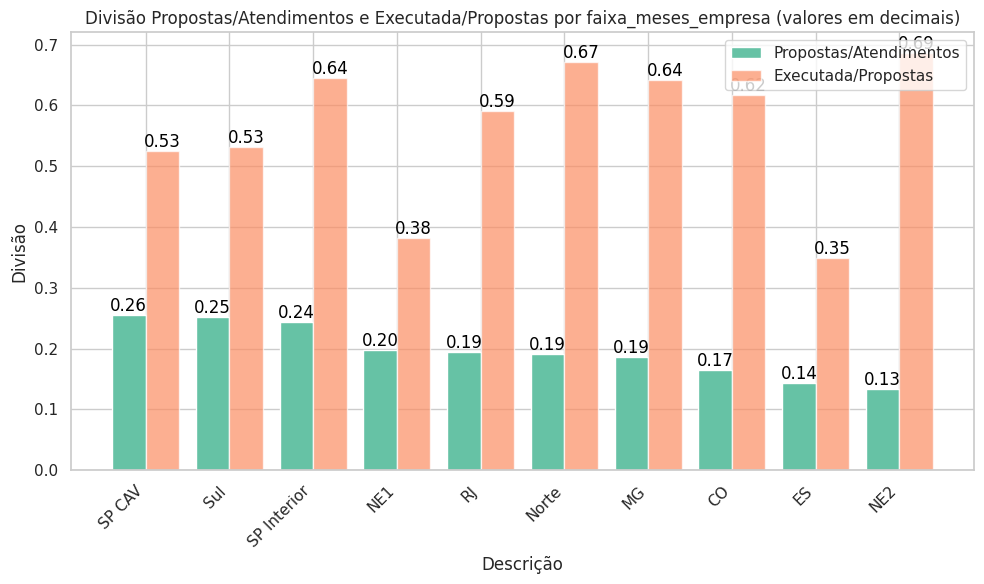

In [19]:
plot_divisoes(soma_por_descricao_sorted)

In [20]:
# Agrupando o DataFrame pela coluna 'faixa_meses_empresa' e calculando as médias para 'conversao_propostas' e 'conversao_atendimento'
soma_por_faixa_meses_empresa = dfp.groupby('faixa_meses_empresa')['total_atendimentos', 'total_propostas', 'total_executada'].sum()

# Calculando as duas novas colunas e adicionando ao DataFrame soma_por_descricao
soma_por_faixa_meses_empresa['divisao_propostas_atendimentos'] = soma_por_faixa_meses_empresa['total_propostas'] / soma_por_faixa_meses_empresa['total_atendimentos']
soma_por_faixa_meses_empresa['divisao_executada_propostas'] = soma_por_faixa_meses_empresa['total_executada'] / soma_por_faixa_meses_empresa['total_propostas']
#ordenando as novas colunas primeiro pela divisao_propostas_atendimentos e depois divisao_executada_propostas
soma_por_faixa_meses_empresa = soma_por_faixa_meses_empresa.sort_values(by=['divisao_propostas_atendimentos', 'divisao_executada_propostas'], ascending=[False, False])

/tmp/ipykernel_1180/1899343117.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  soma_por_faixa_meses_empresa = dfp.groupby('faixa_meses_empresa')['total_atendimentos', 'total_propostas', 'total_executada'].sum()


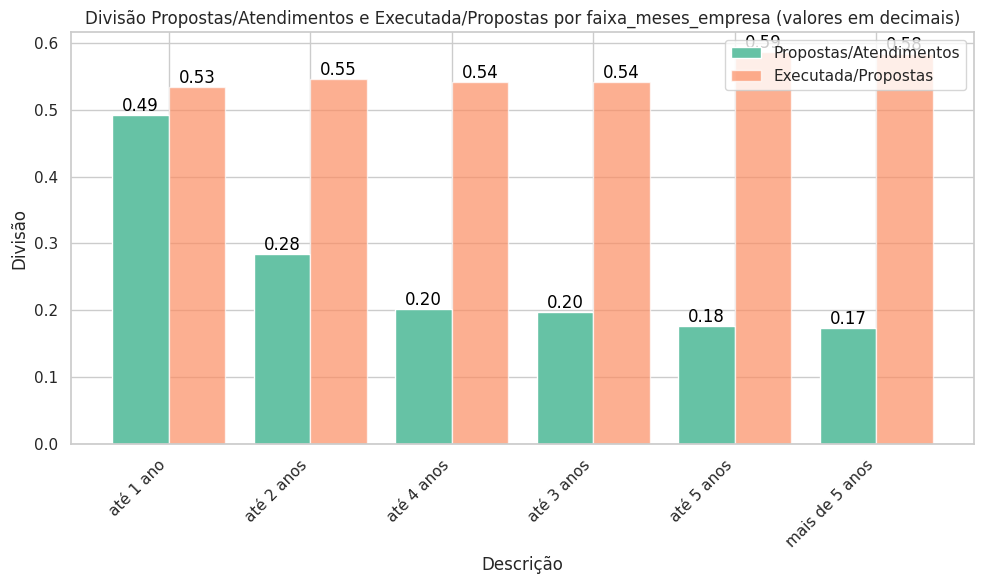

In [21]:
plot_divisoes(soma_por_faixa_meses_empresa)

In [22]:
# Agrupando o DataFrame pela coluna 'sexo' e calculando as médias para 'conversao_propostas' e 'conversao_atendimento'
soma_por_sexo = dfp.groupby('sexo')['total_atendimentos', 'total_propostas', 'total_executada'].sum()

# Calculando as duas novas colunas e adicionando ao DataFrame soma_por_descricao
soma_por_sexo['divisao_propostas_atendimentos'] = soma_por_sexo['total_propostas'] / soma_por_sexo['total_atendimentos']
soma_por_sexo['divisao_executada_propostas'] = soma_por_sexo['total_executada'] / soma_por_sexo['total_propostas']
#ordenando as novas colunas primeiro pela divisao_propostas_atendimentos e depois divisao_executada_propostas
soma_por_sexo = soma_por_sexo.sort_values(by=['divisao_propostas_atendimentos', 'divisao_executada_propostas'], ascending=[False, False])

/tmp/ipykernel_1180/3233155590.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  soma_por_sexo = dfp.groupby('sexo')['total_atendimentos', 'total_propostas', 'total_executada'].sum()


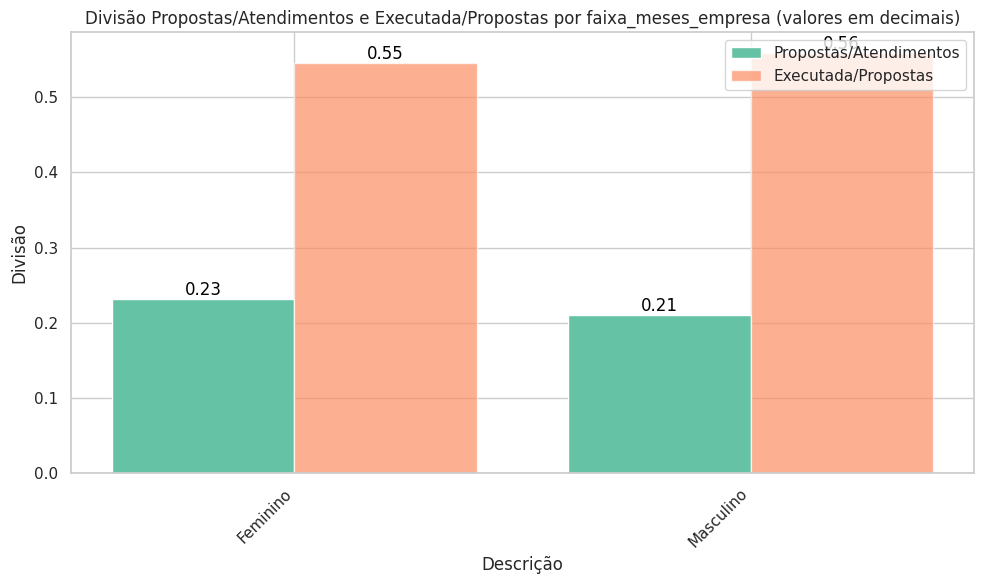

In [23]:
plot_divisoes(soma_por_sexo)

In [24]:
# Agrupando o DataFrame pela coluna 'sexo' e calculando as médias para 'conversao_propostas' e 'conversao_atendimento'
soma_por_faixa_etaria = dfp.groupby('faixa_etaria')['total_atendimentos', 'total_propostas', 'total_executada'].sum()

# Calculando as duas novas colunas e adicionando ao DataFrame soma_por_descricao
soma_por_faixa_etaria['divisao_propostas_atendimentos'] = soma_por_faixa_etaria['total_propostas'] / soma_por_faixa_etaria['total_atendimentos']
soma_por_faixa_etaria['divisao_executada_propostas'] = soma_por_faixa_etaria['total_executada'] / soma_por_faixa_etaria['total_propostas']
#ordenando as novas colunas primeiro pela divisao_propostas_atendimentos e depois divisao_executada_propostas
soma_por_faixa_etaria = soma_por_faixa_etaria.sort_values(by=['divisao_propostas_atendimentos', 'divisao_executada_propostas'], ascending=[False, False])

/tmp/ipykernel_1180/2927707770.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  soma_por_faixa_etaria = dfp.groupby('faixa_etaria')['total_atendimentos', 'total_propostas', 'total_executada'].sum()


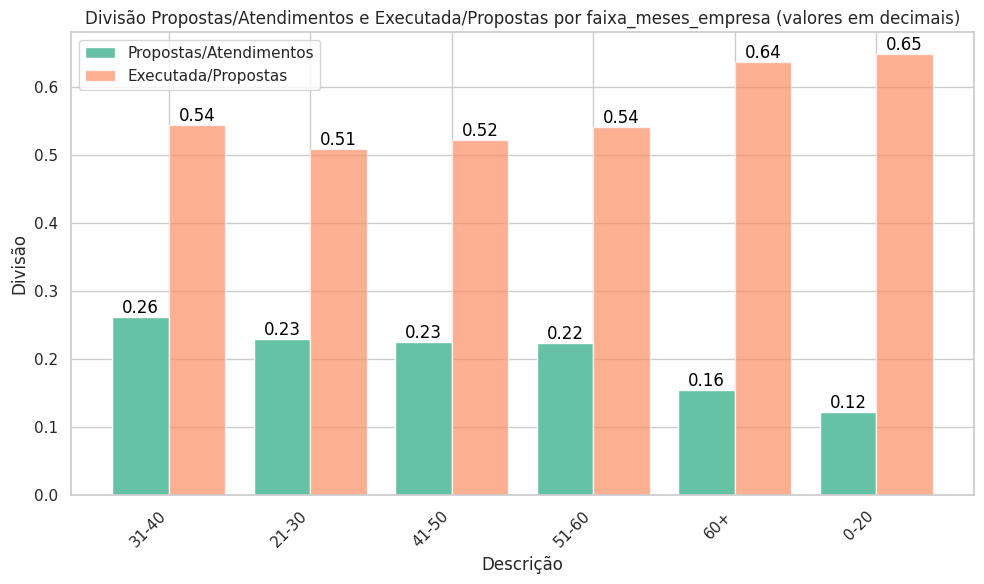

In [25]:
plot_divisoes(soma_por_faixa_etaria)

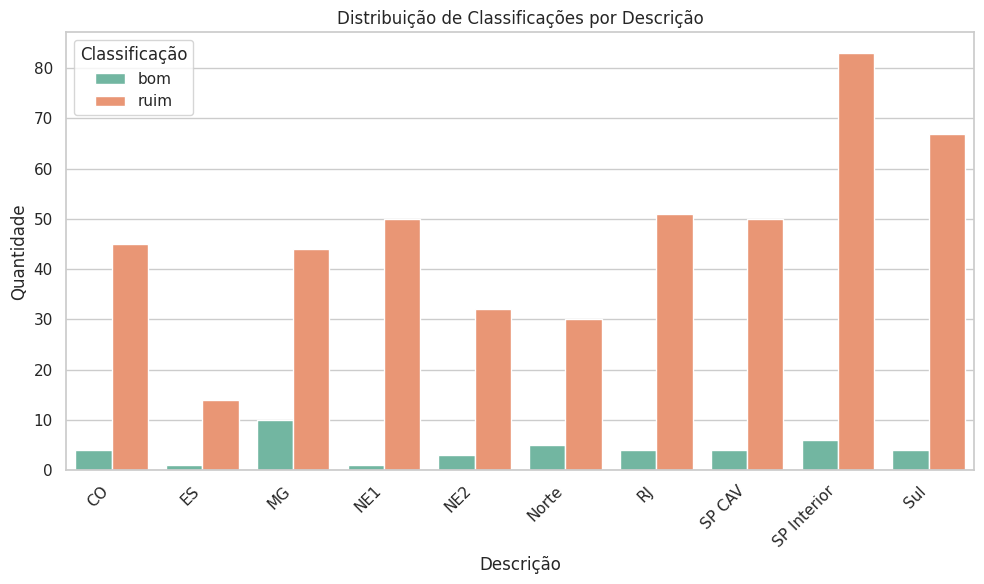

In [26]:
# Criar a coluna 'bool' baseada na coluna 'ambas_classificacoes_1'
dfp['bool'] = dfp['ambas_classificacoes_1'].map({0: 'ruim', 1: 'bom'})

# Agrupar pela coluna 'descricao' e contar a quantidade de 'bom' e 'ruim'
grupo_por_descricao = dfp.groupby(['descricao', 'bool']).size().reset_index(name='quantidade')

# Filtrar os grupos "bom" e "ruim" para o gráfico de barras
grupo_bom = grupo_por_descricao[grupo_por_descricao['bool'] == 'bom']
grupo_ruim = grupo_por_descricao[grupo_por_descricao['bool'] == 'ruim']

# Ordenar os grupos por quantidade
grupo_bom = grupo_bom.sort_values(by='quantidade', ascending=False)
grupo_ruim = grupo_ruim.sort_values(by='quantidade', ascending=False)

sns.set_palette("Set2")

# Plotar o gráfico de barras lado a lado usando Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=grupo_por_descricao, x='descricao', y='quantidade', hue='bool')
plt.title('Distribuição de Classificações por Descrição')
plt.xlabel('Descrição')
plt.ylabel('Quantidade')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Classificação')

plt.tight_layout()
plt.show()

Vinculando a tabela de proposta, e trazendo os valores que foram executados para a analise

In [27]:
itens = '''select sp.profissionalid as id_profissional, sum(sp.valor), count(*),  
sum(sp.valor)/count(*) as ticket_propostas
from stg_propostas sp 
left join stg_itens_proposta sip on sip.proposta_id = sp.id 
left join stg_procedimentos sp2 on sp2.id = sip.item_id
left join stg_procedimentos_grupos spg on spg.id = sp2.grupo_procedimento_id
where sip.item_id > 0
and sp.staid = 5
and sp.profissionalid > 0
group by sp.profissionalid'''

dfp_itens = pd.read_sql_query(itens,con=connection)


/tmp/ipykernel_1180/4173491628.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dfp_itens = pd.read_sql_query(itens,con=connection)


In [28]:
dfp_merged = dfp.merge(dfp_itens, on='id_profissional', how='inner')

In [29]:
dfp_merged

,id_profissional,descricao,nome_profissional,idade,anos_empresa,meses_empresa,sexo_id,sexo,sys_active,total_atendimentos,...,conversao_atendimento,classificacao_propostas,classificacao_atendimento,faixa_meses_empresa,faixa_etaria,ambas_classificacoes_1,bool,sum,count,ticket_propostas
0,504298,SP CAV,Jorge Luis Vivar Sanchez,36.0,1,13,1.0,Masculino,1,377,...,0.506631,0,1,até 2 anos,31-40,0,ruim,5.828702e+05,1612,361.582016
1,165668,SP Interior,Rafael Porto,41.0,3,37,1.0,Masculino,1,2793,...,0.152524,0,0,até 4 anos,41-50,0,ruim,2.036342e+06,7910,257.438942
2,234178,SP CAV,Reyves Lorenzoni Batista,33.0,5,62,1.0,Masculino,1,2601,...,0.427528,0,1,mais de 5 anos,31-40,0,ruim,3.657574e+05,2152,169.961622
3,262469,NE2,Felipe Afonso Gonçalves,40.0,3,39,1.0,Masculino,1,4808,...,0.057612,1,0,até 4 anos,31-40,0,ruim,3.245996e+05,2014,161.171599
4,262469,NE1,Felipe Afonso Gonçalves,40.0,3,39,1.0,Masculino,1,1068,...,0.043071,1,0,até 4 anos,31-40,0,ruim,3.245996e+05,2014,161.171599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,90,SP Interior,Adelaide Silveira Barros,51.0,3,36,2.0,Feminino,1,378,...,0.584656,1,1,até 4 anos,51-60,1,bom,2.391087e+05,967,247.268562
504,511791,RJ,Jorge Eduardo Andrade Negri,75.0,0,1,1.0,Masculino,1,9,...,0.333333,0,0,até 1 ano,60+,0,ruim,2.196000e+03,18,122.000000
505,251233,NE2,Camilo Paiva Cantidio,62.0,4,48,1.0,Masculino,1,2043,...,0.069506,1,0,até 5 anos,60+,0,ruim,1.820756e+05,1667,109.223515
506,225501,Sul,Andre Luiz Ribeiro Gomes Capaverde,43.0,6,69,1.0,Masculino,1,812,...,0.055419,1,0,mais de 5 anos,41-50,0,ruim,1.865153e+05,360,518.098055


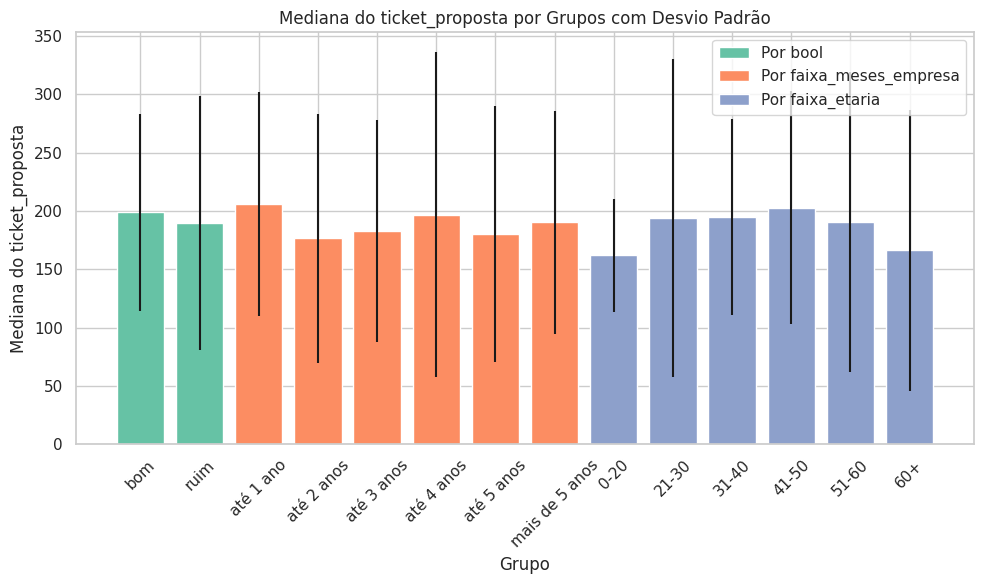

In [30]:
# Agrupar por 'bool' e calcular a mediana e o desvio padrão do 'ticket_proposta'
grupo_por_bool = dfp_merged.groupby('bool')['ticket_propostas'].agg(['median', 'std'])

# Agrupar por 'faixa_meses_empresa' e calcular a mediana e o desvio padrão do 'ticket_proposta'
grupo_por_faixa_meses = dfp_merged.groupby('faixa_meses_empresa')['ticket_propostas'].agg(['median', 'std'])

# Agrupar por 'faixa_etaria' e calcular a mediana e o desvio padrão do 'ticket_proposta'
grupo_por_faixa_etaria = dfp_merged.groupby('faixa_etaria')['ticket_propostas'].agg(['median', 'std'])

sns.set_palette("Set2")

# Criar o gráfico de barras
plt.figure(figsize=(10, 6))

# Plotar as medianas para cada grupo
plt.bar(grupo_por_bool.index, grupo_por_bool['median'], yerr=grupo_por_bool['std'], label='Por bool')
plt.bar(grupo_por_faixa_meses.index, grupo_por_faixa_meses['median'], yerr=grupo_por_faixa_meses['std'], label='Por faixa_meses_empresa')
plt.bar(grupo_por_faixa_etaria.index, grupo_por_faixa_etaria['median'], yerr=grupo_por_faixa_etaria['std'], label='Por faixa_etaria')

# Definir rótulos e título
plt.xlabel('Grupo')
plt.ylabel('Mediana do ticket_proposta')
plt.title('Mediana do ticket_proposta por Grupos com Desvio Padrão')
plt.xticks(rotation=45)
plt.legend()

# Exibir o gráfico
plt.tight_layout()
plt.show()

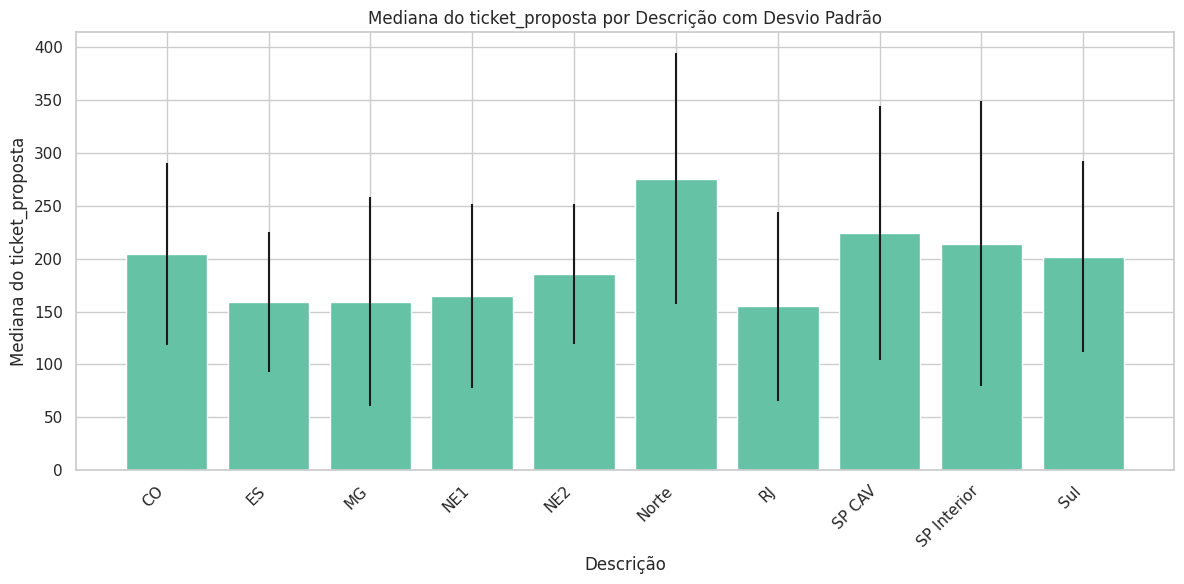

In [31]:
# Agrupar por 'descricao' e calcular a mediana e o desvio padrão do 'ticket_proposta'
grupo_por_descricao = dfp_merged.groupby('descricao')['ticket_propostas'].agg(['median', 'std'])

sns.set_palette("Set2")

# Criar o gráfico de barras
plt.figure(figsize=(12, 6))

# Plotar as medianas para cada grupo
plt.bar(grupo_por_descricao.index, grupo_por_descricao['median'], yerr=grupo_por_descricao['std'])

# Definir rótulos e título
plt.xlabel('Descrição')
plt.ylabel('Mediana do ticket_proposta')
plt.title('Mediana do ticket_proposta por Descrição com Desvio Padrão')
plt.xticks(rotation=45, ha='right')

# Exibir o gráfico
plt.tight_layout()
plt.show()

In [51]:
dfp_ = dfp.dropna()

/tmp/ipykernel_1180/520855019.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp_['cluster'] = cluster_labels


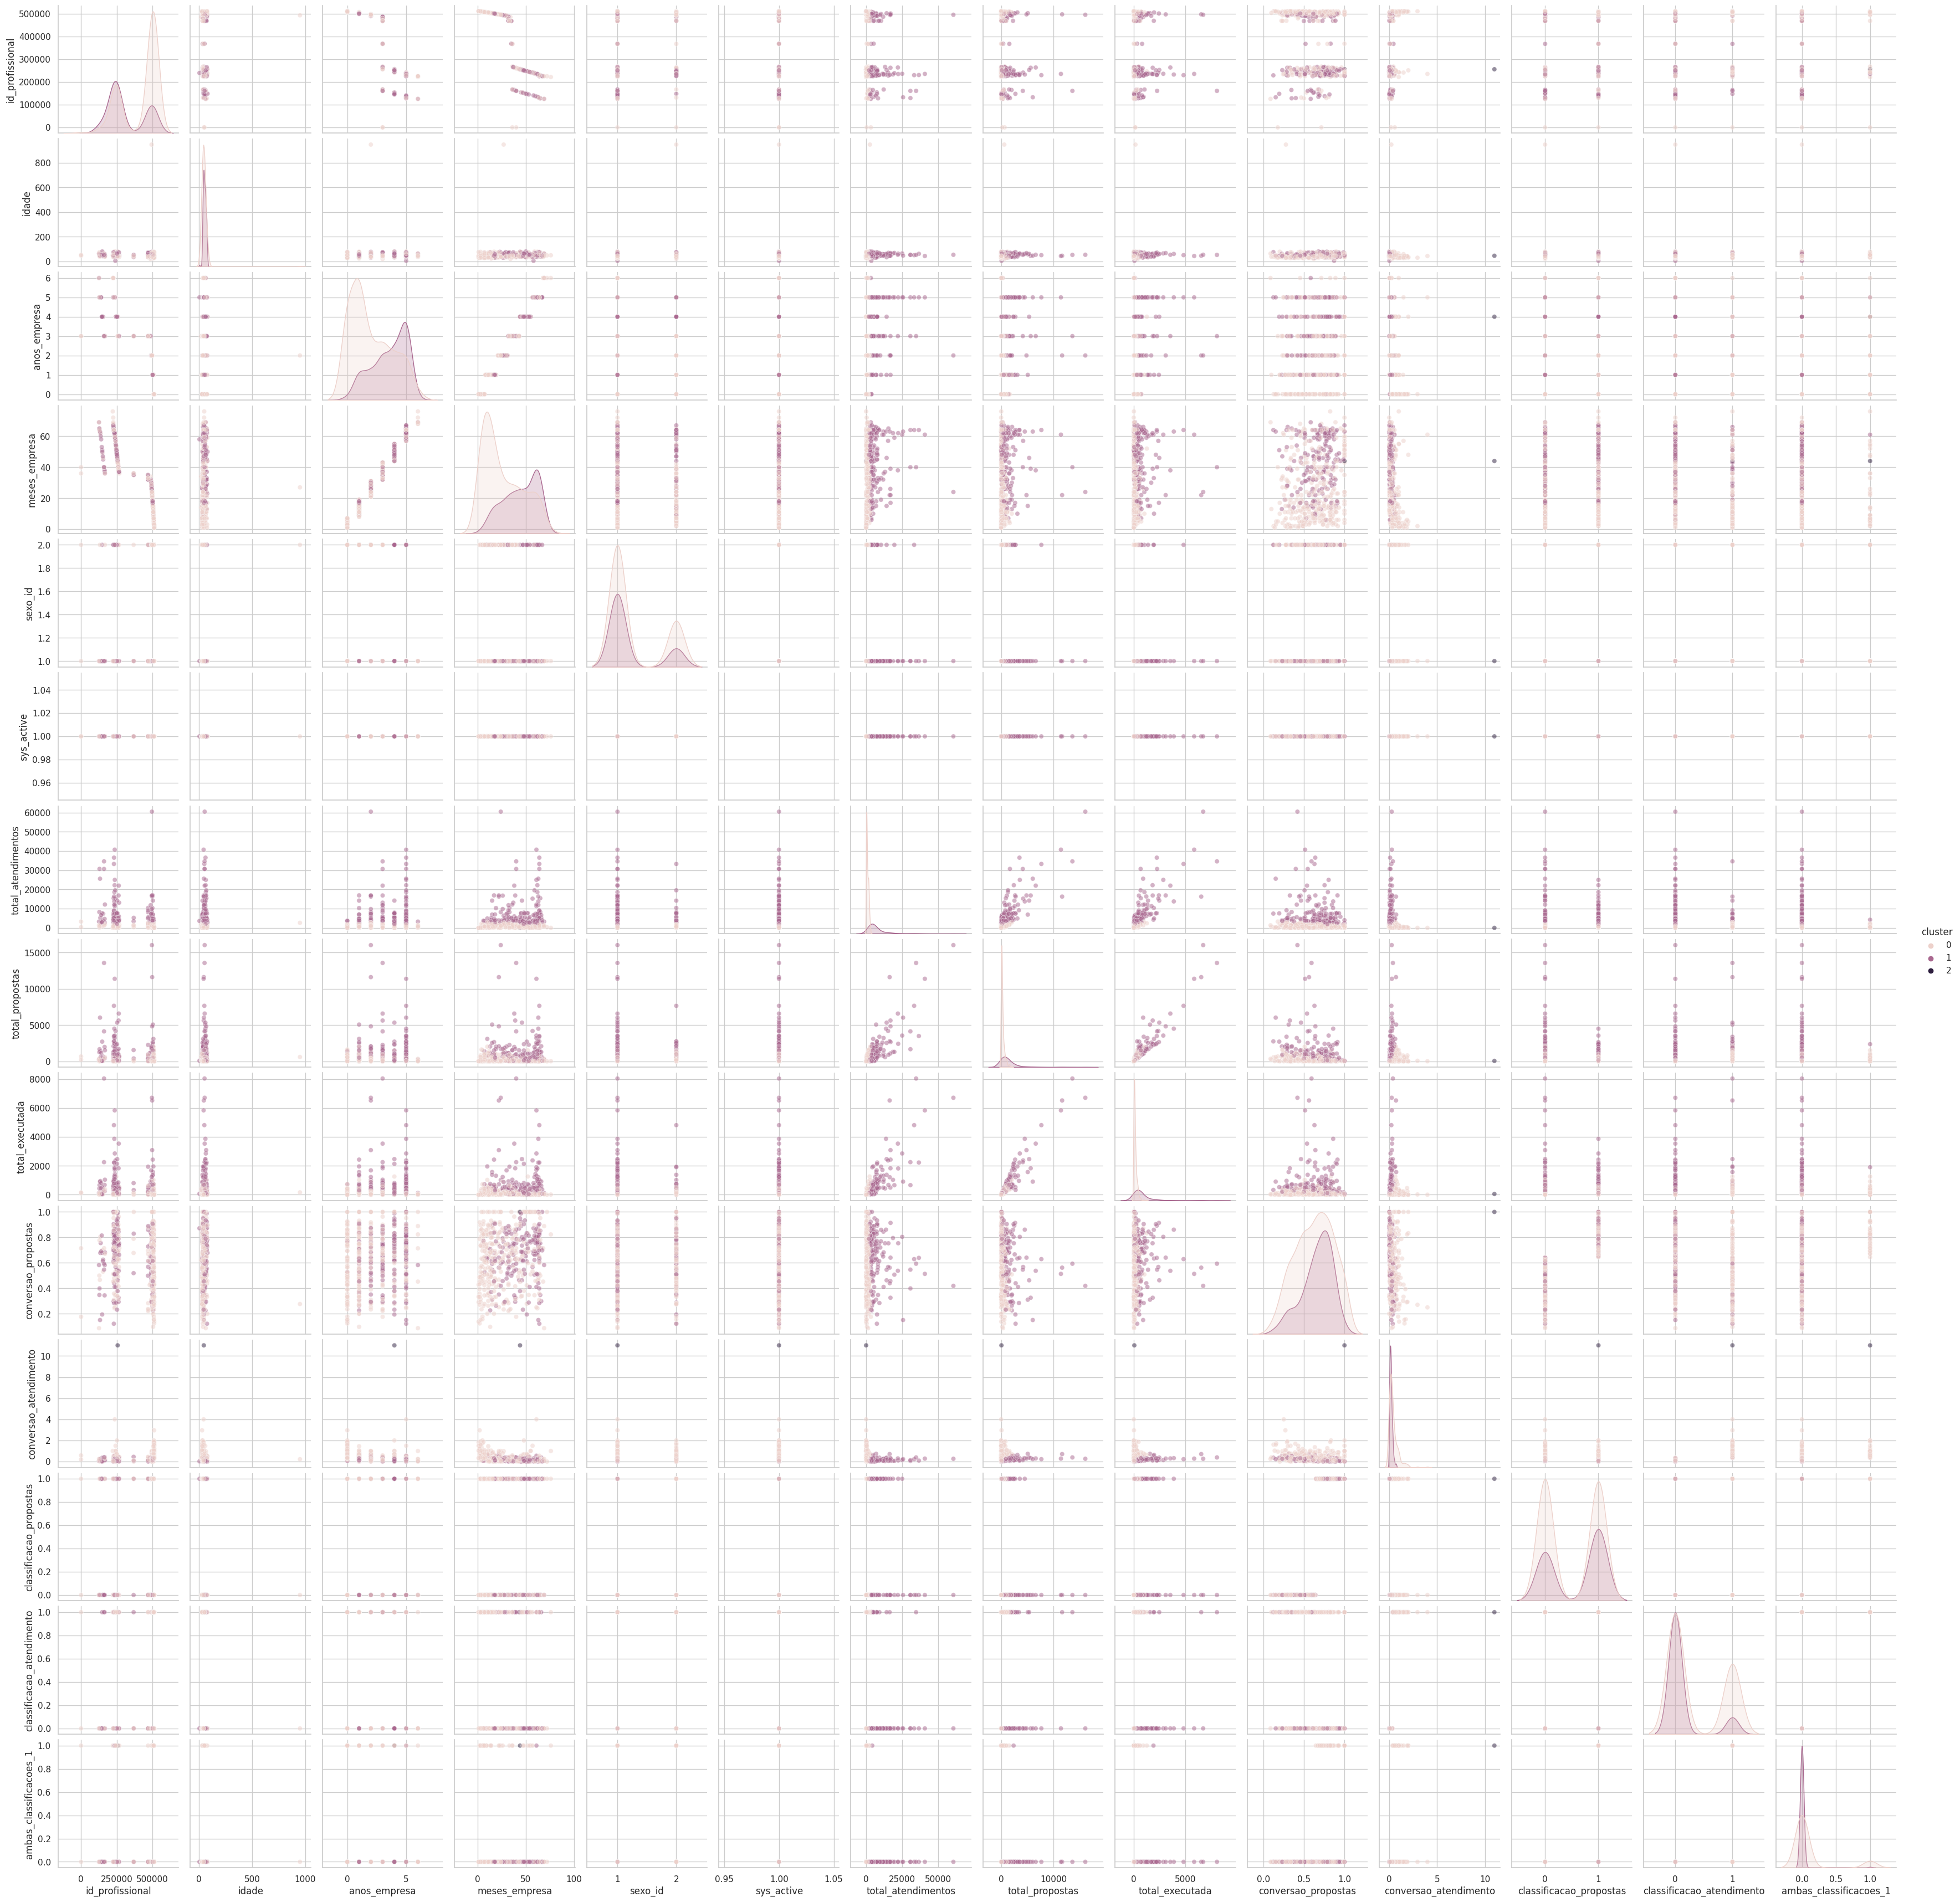

In [39]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

# Selecionar as colunas relevantes para clustering
columns_for_clustering = ['total_atendimentos', 'conversao_propostas', 'conversao_atendimento']

# Filtrar e padronizar os dados
data_for_clustering = dfp_[columns_for_clustering]
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_clustering)

# Criar um modelo Gaussian Mixture com 3 componentes
n_components = 3
gmm = GaussianMixture(n_components=n_components, random_state=42)

# Ajustar o modelo aos dados
gmm.fit(data_scaled)

# Obter as previsões de cluster
cluster_labels = gmm.predict(data_scaled)

# Adicionar os rótulos de cluster ao DataFrame
dfp_['cluster'] = cluster_labels

# Visualizar os resultados
sns.pairplot(dfp_, hue='cluster', diag_kind='kde', plot_kws={'alpha': 0.5})
plt.show()

In [36]:
aaaaa 

NameError: name 'aaaaa' is not defined

Classificação através de Random Florest


In [ ]:
dfp_class = dfp
dfp_class.drop(['id_profissional', 'descricao', 'nome_profissional', 'sexo', 'faixa_meses_empresa', 'faixa_etaria', 'ambas_classificacoes_1', 'bool'],axis=1,inplace=True)

In [ ]:
dfp_class_sem_nan = dfp_class.dropna()

In [ ]:
y_train_propostas

3      1
435    1
182    0
65     0
116    0
      ..
112    1
283    0
363    1
453    1
108    0
Name: classificacao_propostas, Length: 341, dtype: int64

In [ ]:
#Bibliotecas para classificação usando RandomForest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
X = dfp_class_sem_nan.drop(['classificacao_propostas', 'classificacao_atendimento'], axis=1)  # Features
y_propostas = dfp_class_sem_nan['classificacao_propostas']  # Target para classificação de propostas
y_atendimento = dfp_class_sem_nan['classificacao_atendimento']  # Target para classificação de atendimento

In [ ]:
X_train_propostas, X_test_propostas, y_train_propostas, y_test_propostas = train_test_split(X, y_propostas, test_size=0.3, random_state=42)
X_train_atendimento, X_test_atendimento, y_train_atendimento, y_test_atendimento = train_test_split(X, y_atendimento, test_size=0.3, random_state=42)

In [ ]:
rf_propostas = RandomForestClassifier(random_state=42)
rf_propostas.fit(X_train_propostas, y_train_propostas)

rf_atendimento = RandomForestClassifier(random_state=42)
rf_atendimento.fit(X_train_atendimento, y_train_atendimento)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred_propostas = rf_propostas.predict(X_test_propostas)
y_pred_atendimento = rf_atendimento.predict(X_test_atendimento)

In [ ]:
print("Acurácia do modelo de propostas:", accuracy_score(y_test_propostas, y_pred_propostas))
print("Matriz de Confusão do modelo de propostas:")
print(confusion_matrix(y_test_propostas, y_pred_propostas))
print("Relatório de Classificação do modelo de propostas:")
print(classification_report(y_test_propostas, y_pred_propostas))

print("Acurácia do modelo de atendimento:", accuracy_score(y_test_atendimento, y_pred_atendimento))
print("Matriz de Confusão do modelo de atendimento:")
print(confusion_matrix(y_test_atendimento, y_pred_atendimento))
print("Relatório de Classificação do modelo de atendimento:")
print(classification_report(y_test_atendimento, y_pred_atendimento))

Acurácia do modelo de propostas: 1.0
Matriz de Confusão do modelo de propostas:
[[73  0]
 [ 0 74]]
Relatório de Classificação do modelo de propostas:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        73
           1       1.00      1.00      1.00        74

    accuracy                           1.00       147
   macro avg       1.00      1.00      1.00       147
weighted avg       1.00      1.00      1.00       147

Acurácia do modelo de atendimento: 1.0
Matriz de Confusão do modelo de atendimento:
[[105   0]
 [  0  42]]
Relatório de Classificação do modelo de atendimento:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       105
           1       1.00      1.00      1.00        42

    accuracy                           1.00       147
   macro avg       1.00      1.00      1.00       147
weighted avg       1.00      1.00      1.00       147



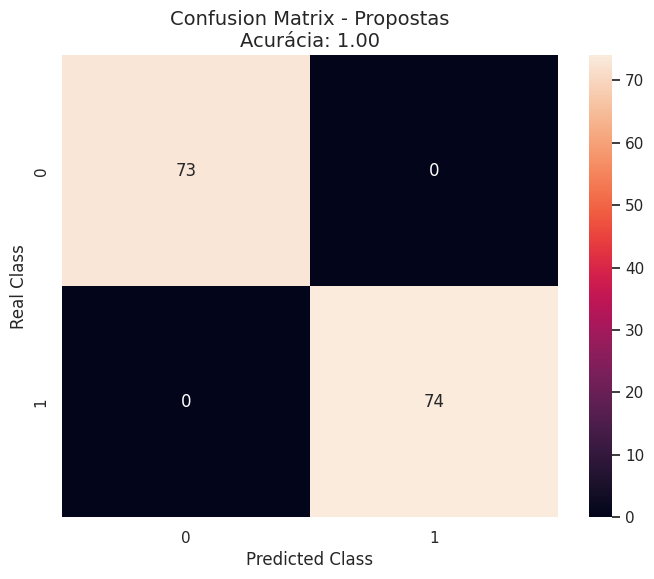

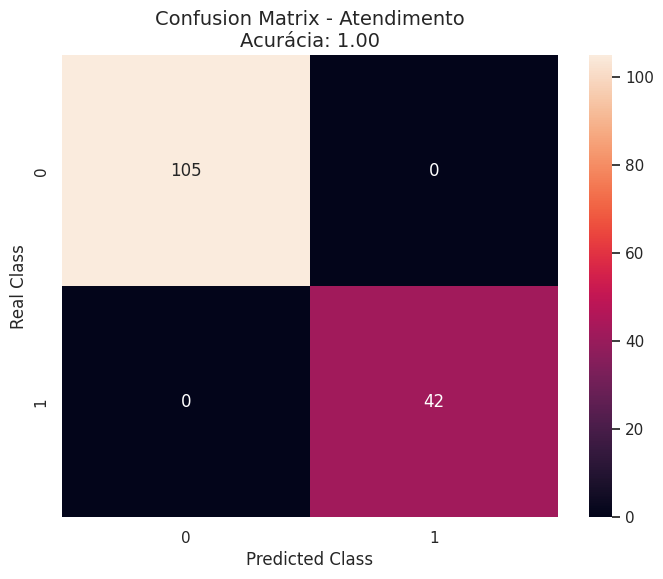

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# Calcula a acurácia e obtém as matrizes de confusão
accuracy_propostas = accuracy_score(y_test_propostas, y_pred_propostas)
conf_matrix_propostas = confusion_matrix(y_test_propostas, y_pred_propostas)

accuracy_atendimento = accuracy_score(y_test_atendimento, y_pred_atendimento)
conf_matrix_atendimento = confusion_matrix(y_test_atendimento, y_pred_atendimento)

# Plot da matriz de confusão para o modelo de propostas
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_propostas, annot=True, fmt='g')
plt.title(f'Confusion Matrix - Propostas\nAcurácia: {accuracy_propostas:.2f}', fontsize=14)
plt.ylabel('Real Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.show()

# Plot da matriz de confusão para o modelo de atendimento
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_atendimento, annot=True, fmt='g')
plt.title(f'Confusion Matrix - Atendimento\nAcurácia: {accuracy_atendimento:.2f}', fontsize=14)
plt.ylabel('Real Class', fontsize=12)
plt.xlabel('Predicted Class', fontsize=12)
plt.show()
